In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Methods for implementing functions from https://arxiv.org/pdf/1906.00285.pdf

In [2]:
def P_alpha(alpha, df_311, df_census):
    '''
    method for finding P(A=alpha) from the paper, used in equation (7).
    estimates the percent of requests from a given demographic

    :param alpha: a *set* of census codes (not necessarily just one) describing the demographic group (i.e. {B03002003, B03002013} for hispanic and non-hispanic white people)
    :param df_311: the dataframe of 311 data to look through
    :param df_census: the dataframe of census data (called "demographics_table" in the box repository)
    :return: the estimated percent of 311 records from people of that demographic.
    '''

    # get a new vector indexed by block groups, containing the number of requests from each block group
    bg_counts = df_311['BLOCK_GROUP'].value_counts()

    # get a vector 'bg_ratios' decribing the % of people in each block group from the demographic in question
    # B03002001 is the census code for total population

    def ratio_calc(row):
        total = row['B03002001 - count']
        if total == 0: return 0
        return sum([row[code + ' - count'] for code in alpha]) / total

    bg_ratios = df_census.apply(lambda row: ratio_calc(row), axis=1)

    # some block groups never appear in the 311 data, so bg_ratios has more elements than bg_counts
    # accordingly, we need to get rid of the indices in bg_ratios that don't have a matching index in bg_counts
    # (we need to do this because next we're going to take the dot product)
    bgs_in_311 = set(bg_counts.index)
    bgs_in_census = set(bg_ratios.index)
    bgs_just_in_census = bgs_in_census.difference(bgs_in_311)
    bg_ratios.drop(labels = list(bgs_just_in_census), inplace=True)


    #now the dot product of bg_counts and bg_ratios should be the approx number of requests from the demographic alpha
    return bg_counts.dot(bg_ratios)

In [3]:
def mu(w, alpha, df_311, df_census):
    '''
    implements the function mu(alpha; w) from eq. (7) of the paper

    :param w: another function, called within mu
    :param alpha: a demographic, and a parameter for w. expressed as a set of census codes.
    :param df_311: dataframe of 311 data
    :param df_census: dataframe of census data
    :return: mu(alpha; w)
    '''

    # two parts: first, take the expectation of mu_alpha(Y hat, Z) * Y hat over all Y hat and Z
    # then divide that by P(A = alpha)

    # part 1.

    # first, get a list of all Z (all block groups)

    Z = list(df_311['BLOCK_GROUP'].value_counts().index)

    # now, the expectation is the sum over all Y hat and Z of P(Y hat, Z) * (w_alpha(Y hat, Z) * Y hat)
    # but since we're multiplying by Y hat at the end, that means that when Y hat = 0 we're guaranteed to not contribute anything to the sum
    # so we really just need to sum over all Z, keeping Y hat fixed as 1.

    expectation = 0
    total_records = len(df_311)
    for z in Z:
        w_result = w(alpha, 1, z, df_311, df_census)

        P_Yhat_Z = len(df_311.loc[df_311['BLOCK_GROUP'] == z].loc[df_311['LABEL'] == 1]) / total_records

        expectation += w_result * P_Yhat_Z

    # part 2. P(A = alpha) is handled by another function
    P_A_equals_alpha = P_alpha(alpha, df_311, df_census)

    return expectation / P_A_equals_alpha

In [4]:
def P_alpha_given_z(alpha, z, df_census):
    '''
    calculates P(A=alpha|Z=z) as used in the definitions of w^L_alpha and w^U_alpha at the top of page 15 of the paper

    :param alpha: demographic -- technically, a set of census codes
    :param z: a block group
    :param df_census: dataframe of census data
    :return: P(A=alpha | Z=z)
    '''

    # since alpha is a set of census codes we need to take the sum of census population counts over all of the codes (within the given block group), then divide that sum by the total population of the block group

    alpha_population = sum([df_census.loc[z, code + ' - count'] for code in list(alpha)])
    total_population = df_census.loc[z, 'B03002001 - count'] # B03002001 is the census ocde for total population


    # catch divide by 0 errors:
    if total_population == 0: return 0
    # else...
    return alpha_population / total_population

In [5]:
def P_y_hat_given_z(y_hat,z,df_311):
    '''
    calculates P(Y hat=y hat | Z=z) as used in the definitions of w^L_alpha and w^U_alpha at the top of page 15 of the paper

    :param Y_hat: label
    :param z: block group
    :param df_311: dataframe of 311 data
    :return: P(Y hat = y_hat | Z = z)
    '''

    # first slim down the dataset to all the records where Z=z
    df_z = df_311.loc[df_311['BLOCK_GROUP'] == z]

    # get the total number of records from this block group
    total_records_from_z = len(df_z)

    # catch a divide by 0 error
    if total_records_from_z == 0: return 0
    # else...
    return len(df_z.loc[df_z['LABEL'] == y_hat]) / total_records_from_z

In [6]:
def w_L(alpha, y_hat, z, df_311, df_census):

    numerator = P_alpha_given_z(alpha, z, df_census) - 1
    denominator = P_y_hat_given_z(y_hat, z, df_311)

    # first we need to catch the divide by zero error
    if denominator == 0: return 0
    # if the denominator is 0, it doesn't matter what we return, because if P(y hat | z) is 0 then P(y hat, z) is also zero, meaning that what we return here won't contribute at all to the expectation that mu is calculating anyhow.

    return max(0, 1 + numerator/ denominator)

    #ratio = (P_alpha_given_z(alpha, z, df_census) - 1)/ P_y_hat_given_z(y_hat, z, df_311)
    #return max(0, 1 + ratio)

In [7]:
def w_U(alpha, y_hat, z, df_311, df_census):
    numerator = P_alpha_given_z(alpha, z, df_census)
    denominator = P_y_hat_given_z(y_hat, z, df_311)

    # first we need to catch the divide by zero error
    if denominator == 0: return 0
    # if the denominator is 0, it doesn't matter what we return, because if P(y hat | z) is zero then P(y hat, z) is also zero, meaning that what we return here won't contribute at all to the expectation that mu is calculating anyhow.

    return min(1, numerator / denominator)

In [8]:
def Delta(a, b, df_311, df_census):

    # p_a = P_alpha(a, df_311, df_census)
    # p_b = 1 - p_a


    lower_bound = mu(w_L, a, df_311, df_census) - mu(w_U, b, df_311, df_census)
    upper_bound = mu(w_U, a, df_311, df_census) - mu(w_L, b, df_311, df_census)
    return lower_bound, upper_bound

### Methods for creating the dataframes and calling the above functions appropriately

In [9]:
def read_and_annotate_311(path, threshhold):
    '''
    reads in a CSV of 311 request data as dataframe, annotates it with a new column, 'LABEL'
    'LABEL' = 0 or 1 depending on if the request was completed in more than or less than the thresshold time
    (so 1 = quicker response)
    lastly, it returns the dataframe

    :param path: filepath to read from
    :param threshhold: a number of seconds
    :return: a pandas dataframe
    '''

    df = pd.read_csv(path, index_col=0, dtype={'CITY': np.str, 'STATE': np.str, 'ZIP_CODE': np.str,
                                               'STREET_NUMBER': np.str, 'LEGACY_SR_NUMBER': np.str,
                                               'PARENT_SR_NUMBER': np.str, 'SANITATION_DIVISION_DAYS': np.str,
                                               'BLOCK_GROUP': np.str})  # get a bunch of warnings unless you specify the datatype for these guys

    df['LABEL'] = df.apply(lambda row: 1 if row['DELTA'] <= threshhold else 0, axis=1)

    return df

In [10]:
def read_census(path):
    '''
    just reads in the census data as a dataframe
    the only special thing going on here is that we need to make sure the first column of the csv is read in as the index for the dataframe
    :param path: path to the census data as a csv
    :return: dataframe
    '''
    df = pd.read_csv(path, index_col=0,)
    df.set_index(df.index.astype(str), drop=False, inplace=True) # the 311 data has block groups as strings, not ints -- the conversion here makes things easier
    return df

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5
25.0
25.5
26.0
26.5
27.0
27.5
28.0
28.5
29.0
29.5


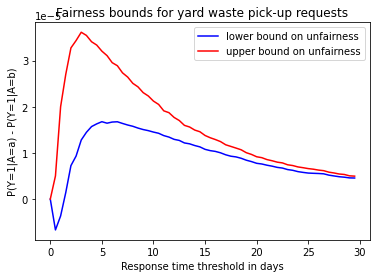

In [13]:
# a is the advantaged group in the paper
a = {'B03002003'}

a =  {
'B03002003',
'B03002005',
'B03002006',
'B03002007',
'B03002008',
'B03002009',
'B03002010',
'B03002011',
'B03002013',
'B03002015',
'B03002016',
'B03002017',
'B03002018',
'B03002019',
'B03002020',
'B03002021'
}
b = {'B03002004','B03002014'}


lower_bounds = []
upper_bounds = []
days = [a/2 for a in range(60)]

df_census = read_census('311 Data/Block groups and demographics/demographics_table.csv')
results = pd.DataFrame(columns=['day','lower bound','upper bound'])

for d in days:
    print(d)
    df_311 = read_and_annotate_311('311 Data/311 data by request type/311_SCQ.csv', d*60*60*24)
    low, up = Delta(a, b, df_311, df_census)
    lower_bounds.append(low)
    upper_bounds.append(up)
    new_row = {'day':d, 'lower bound':low, 'upper bound':up}
    results = results.append(new_row, ignore_index=True)

results.to_csv('results.csv')

fig, ax = plt.subplots()

ax.plot(days, lower_bounds, label='lower bound on unfairness', color='b')
ax.plot(days, upper_bounds, label='upper bound on unfairness', color='r')
ax.legend()
plt.title('Fairness bounds for yard waste pick-up requests')
plt.xlabel('Response time threshold in days')
plt.ylabel('P(Y=1|A=a) - P(Y=1|A=b)')
plt.savefig('')
plt.show()